# Шаг 1: Записать уравнение

$$
\frac{\partial c}{\partial t} = \frac{\partial c}{\partial x} (D \frac{\partial c}{\partial x})
$$
$$
c(x,0) = c_0
$$
$$
c(0,t) = c_L
$$
$$
c(N-1,t) = c_R
$$

# Шаг 2: Дискретизация системы

left: $ \frac{c^{n+1}_0 - c^{n}_0}{\Delta t} = \frac{1}{h}(D_{\frac{1}{2}} \frac{c^{n+1}_1 - c^{n+1}_0}{h} - D_0 \frac{c^{n+1}_0 - c_L}{h})$

middle: $ \frac{c^{n+1}_i - c^{n}_i}{\Delta t} = \frac{1}{h}(D_{i + \frac{1}{2}} \frac{c^{n+1}_{i+1} - c^{n+1}_{i}}{h} - D_{i - \frac{1}{2}} \frac{c^{n+1}_{i} - c^{n+1}_{i-1}}{h})$

right: $ \frac{c^{n+1}_{N-1} - c^{n}_{N-1}}{\Delta t} = \frac{1}{h}(D_{N-1} \frac{c_R - c^{n+1}_{N-1}}{h} - D_{N - \frac{3}{2}} \frac{c^{n+1}_{N-1} - c^{n+1}_{N-2}}{h})$

Переписываем в виде: $Ac^{n+1} - Bc^n = 0$

# Шаг 3: Решаем уравнение

In [23]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)
%matplotlib inline

In [24]:
class Solve_diff:
    def __init__(self, Nx, Nt, L, T_end, init, left, right):
        self.Nx = Nx
        self.Nt = Nt
        self.L = L
        self.T_end = T_end
        self.init = init
        self.lc = left
        self.rc = right
        
    def solve(self, D):
        Nx = self.Nx
        Nt= self.Nt
        self.x = np.linspace(0.1,self.L+0.1,self.Nx)
        
        CTR = np.zeros((Nx,Nt))
        CTR[:,0] = np.exp(-(self.x - 2*np.pi)**2 / (8*np.pi))
        CTR[0,:] = self.lc
        CTR[Nx-1,:] = self.rc
        dd = (self.L / (self.Nx-1))**2 / (T_end / (Nt - 1))
        
        def DD(i): return D[i] + D[i-1] / 2
        
        A = np.zeros((Nx,Nx, Nt))
        b = np.zeros((Nx,Nt))
        B = np.eye(Nx) * dd
        
        for j in range(self.Nt-1):
            A[0,0,j] = - (DD(1) + D[0] + dd)
            A[0,1,j] = DD(1)
            A[Nx-1,Nx-1,j] = -(DD(Nx-1) + D[Nx-1] + dd)
            A[Nx-1,Nx-2,j] = DD(Nx-1)
            
            b[0,j] = - D[0] * self.lc - dd * self.lc
            b[Nx-1,j] = -D[Nx-1] * self.rc - dd * self.rc
            
            for i in range(1,Nx-1):
                A[i,i,j] = - (DD(i+1) + DD(i) + dd)
                A[i,i+1,j] = DD(i+1)
                A[i,i-1,j] = DD(i)
                b[i,j] = - dd * CTR[i,j]
            
            CTR[:,j+1] = np.linalg.solve(A[:,:,j], b[:,j])
                
        return CTR, A, B

Проверим решение

In [25]:
Nx=51
Nt=1001 
L = 4*np.pi
T_end = 1000
init = 0 
left = 0.4
right = 0.4

In [26]:
solver = Solve_diff(Nx=Nx, Nt=Nt, L = L, T_end = T_end, init = init, left = left, right = right) 

In [27]:
x = np.linspace(0, L, Nx)
D = np.sin(x) + 1.1

In [28]:
CTR, A, B = solver.solve(D)

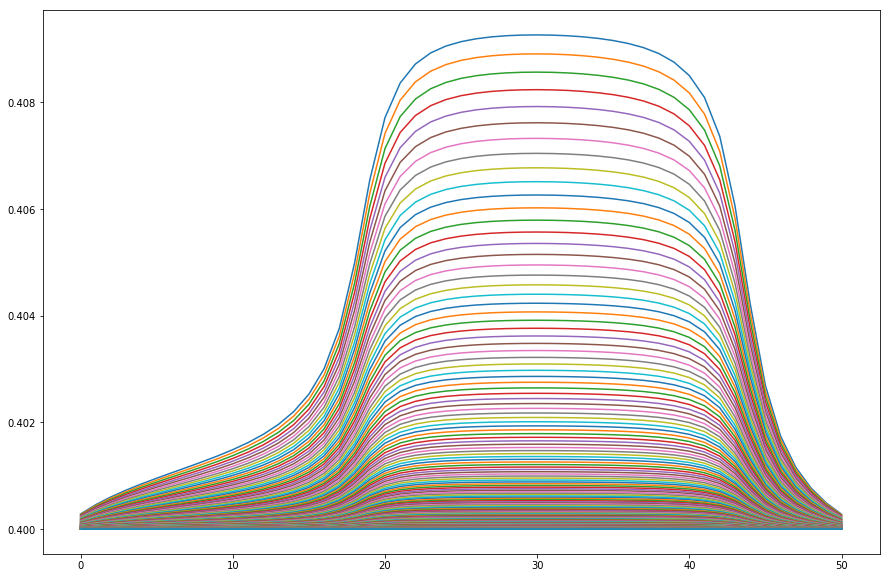

In [29]:
plt.figure(figsize=(15,10))
for j in range(100, Nt):
    plt.plot(CTR[:,j])

Теперь напишем функционал для оптимизации без учета априорной информации о коэффициенте диффузии:

$$
\underset{x}{\text min} [J = \frac{1}{2} (C(D) - C_{data})(C(D) - C_{data})^T]
$$

Так проще, потому что тогда:
$$
\frac{\partial J}{\partial D} = 0
$$
$$
\frac{\partial J}{\partial C} = C(D) - C_{data}
$$

In [30]:
class With_cost(Solve_diff):
    def __init__(self, Nx, Nt, L, T_end, init, left, right, Cdata):
        self.Nx = Nx
        self.Nt = Nt
        self.L = L
        self.T_end = T_end
        self.init = init
        self.lc = left
        self.rc = right
        self.Cdata = Cdata
        
    def cost(self, D):
        C, _, _ = self.solve(D)
        val = 0
        #mul = np.zeros((self.Nx, self.Nx, self.Nt))
        
        #for j in range(self.Nt):
        #    mul[:,:,j] = (C[:,j] - self.Cdata[:,j]) @ (C[:,j] - self.Cdata[:,j]).T
        #Cd_temp = np.sum(mul, axis = 2) / (self.Nt - 1)
        #Cd = np.linalg.inv(Cd_temp)
        
        for j in range(self.Nt):
         #   dob = 0.5 * np.sum((C[:,j] - self.Cdata[:,j]).T @ Cd @ (C[:,j] - self.Cdata[:,j]))
            dob = 0.5 * np.sum((C[:,j] - self.Cdata[:,j]).T @ (C[:,j] - self.Cdata[:,j]))
            #print(f"timestep = {j}, dob = {dob}")
            val += dob
        return val

In [31]:
cost_solver = With_cost(Nx=Nx, Nt=Nt, L = L, T_end = T_end, init = init, left = left, right = right, Cdata = CTR)

In [32]:
cost = cost_solver.cost(D)

In [33]:
cost

0.0

In [34]:
cost = cost_solver.cost(D+1)

In [35]:
cost

13.58425581487171

Супер, есть солвер и есть функционал, теперь осталось написать метод для нахождения градиента

Здесь надо написать уравнения на аджоинт

In [36]:
class Gradient(Solve_diff):
    def __init__(self, Nx, Nt, L, T_end, init, left, right, Cdata):
        self.Nx = Nx
        self.Nt = Nt
        self.L = L
        self.T_end = T_end
        self.init = init
        self.lc = left
        self.rc = right
        self.Cdata = Cdata
        
    def gradf(self,D):
        
        lam = np.zeros((Nx,Nt))
        CTR, A, B = self.solve(D) 
        
        lam[:,Nt-1] = - np.linalg.inv((A[:,:,Nt-2])) @ (CTR[:,Nt-1] - self.Cdata[:,Nt-1])
        for j in range(Nt-2,0,-1):
            lam[:,j] = - np.linalg.inv((A[:,:,j-1])) @ ((CTR[:,j] - self.Cdata[:,j]) + lam[:,j+1] @ (-B))

        
        G = np.zeros((Nx,Nx,Nt))
        
        for j in range(Nt-1):
            G[0,0,j] = - 3*CTR[0,j+1]/2 + CTR[1,j+1]/2 + self.lc
            G[0,1,j] = -CTR[0,j+1]/2 + CTR[1,j+1]/2
            G[Nx-1,Nx-1,j] = CTR[Nx-2,j+1]/2 - 3*CTR[Nx-1,j+1]/2 + self.rc
            G[Nx-1,Nx-2,j] = CTR[Nx-2,j+1]/2 - CTR[Nx-1,j+1]/2
            
            for i in range(1,Nx-1):
                G[i,i,j] = CTR[i-1,j+1]/2 - CTR[i,j+1] + CTR[i+1,j+1]
                G[i,i+1,j] = CTR[i-1,j+1]/2 - CTR[i,j+1]/2
                G[i,i-1,j] = - CTR[i,j+1]/2 + CTR[i+1,j+1]/2
        
                
        grad = np.zeros(Nx)
        for j in range(Nt-1):
            grad += G[:,:,j] @ lam[:,j+1]
        
        grad = grad / (np.linalg.norm(grad)+1e-8)
        
        return -grad

In [37]:
gradf = Gradient(Nx=Nx, Nt=Nt, L = L, T_end = T_end, init = init, left = left, right = right, Cdata = CTR)

In [38]:
gradient = gradf.gradf(D)

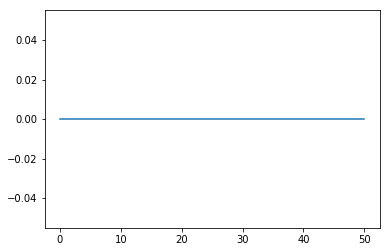

In [39]:
plt.plot(gradient)

In [40]:
gradient = gradf.gradf(D+1)

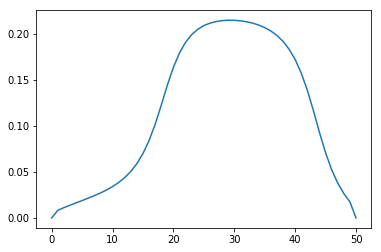

In [41]:
plt.plot(gradient)

Проверим полученное решение

In [42]:
def GradientDescent(fun, grad, x0,  num_iter, eps, **kwargs):
    x_prev = x0.copy()
    
    iteration = 0

    less = False
    alpha = 1
    x_new = np.zeros(len(x_prev))
    
    sk_prev = - grad(x_prev)
    while True:
        
        if less == True:
            alpha *= 0.5
        
        x_new = x_prev + alpha * sk_prev

        if np.any(x_new <= 0):
            x_new = np.abs(x_new)
        
        gain = (x_new - x_prev) / x_prev
        if gain.T @ gain < eps:
            print(f"gain less that {eps}")
            break

        g_new = grad(x_new)
        g_prev = grad(x_prev)
        f_new = fun(x_new)
        f_prev = fun(x_prev)
        
        pr = (g_new.T @ (g_new - g_prev)) / (g_prev.T @ g_prev)
        #fr = (g_new.T @ g_new) / (gradient.T @ gradient)
        w = np.maximum(0, pr)
        #w = fr    
        
        sk_prev = - g_new + sk_prev * w
        #sk_prev = sk_prev * w
        
        if f_new < f_prev:
            x_prev = x_new
            alpha = 1
            less = False
            
        else:
            less = True
            
            
        print(f"CFV = {f_prev}, less = {less}, alpha = {alpha}, GS = {np.sign(g_prev.T @ g_new)}")
        
        iteration += 1

        if iteration >= num_iter:
            break
        
    res = x_prev
    return res

In [43]:
x0 = D.copy()
x0[15] = 5
x0[16] = 5

In [44]:
result = GradientDescent(fun=cost_solver.cost, grad=gradf.gradf, x0=x0, num_iter=30, eps=1e-8)

CFV = 0.17939467507854417, less = True, alpha = 1, GS = -1.0
CFV = 0.17939467507854417, less = True, alpha = 0.5, GS = -1.0
CFV = 0.17939467507854417, less = True, alpha = 0.25, GS = -1.0
CFV = 0.17939467507854417, less = True, alpha = 0.125, GS = -1.0
CFV = 0.17939467507854417, less = True, alpha = 0.0625, GS = -1.0
CFV = 0.17939467507854417, less = True, alpha = 0.03125, GS = -1.0
CFV = 0.17939467507854417, less = True, alpha = 0.015625, GS = -1.0
CFV = 0.17939467507854417, less = True, alpha = 0.0078125, GS = -1.0
CFV = 0.17939467507854417, less = True, alpha = 0.00390625, GS = -1.0
CFV = 0.17939467507854417, less = True, alpha = 0.001953125, GS = -1.0
CFV = 0.17939467507854417, less = True, alpha = 0.0009765625, GS = -1.0
CFV = 0.17939467507854417, less = True, alpha = 0.00048828125, GS = -1.0
CFV = 0.17939467507854417, less = True, alpha = 0.000244140625, GS = -1.0
CFV = 0.17939467507854417, less = True, alpha = 0.0001220703125, GS = -1.0
CFV = 0.17939467507854417, less = True, al

Посмотрим полученное решение и сравним с историческими данными

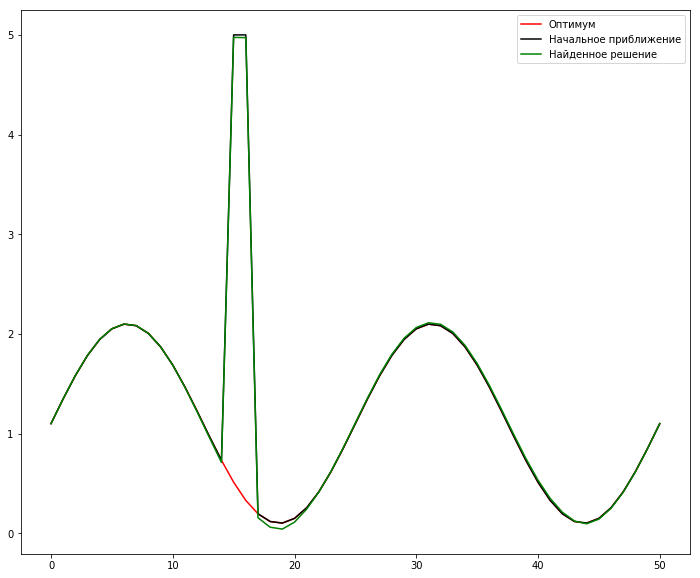

In [45]:
plt.figure(figsize=(12, 10))
plt.plot(D, 'r', label='Оптимум')
plt.plot(x0, 'k', label='Начальное приближение')
plt.plot(result, 'g', label='Найденное решение')
plt.legend(loc='best')
plt.savefig('new_adj.png')

# Теперь посмотрим, как улучшится результат, если использовать априорную информацию о распределении

## Шаг 5: Генерирую выборки из нормального распределения

In [164]:
N_samples = 50 # Количество реализаций коэфициента диффузии
mu = 5 # среднее
sig = 1 # std

In [170]:
normal_coefs = np.zeros((Nx,N_samples))
for sample in range(N_samples):
    normal_coefs[:,sample] = np.random.normal(loc=mu, scale=sig,size=Nx)


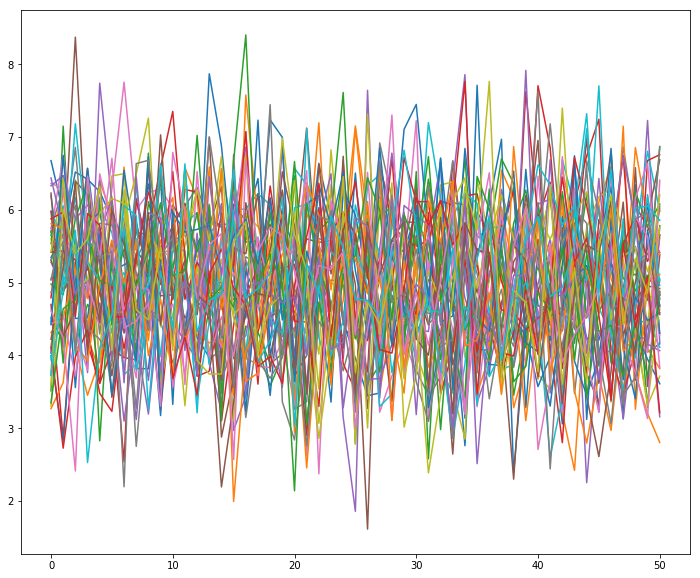

In [171]:
plt.figure(figsize=(12,10))
for j in range(N_samples):
    plt.plot(normal_coefs[:,j])

Пусть первая реализация - априорное распределение коэффициента диффузии

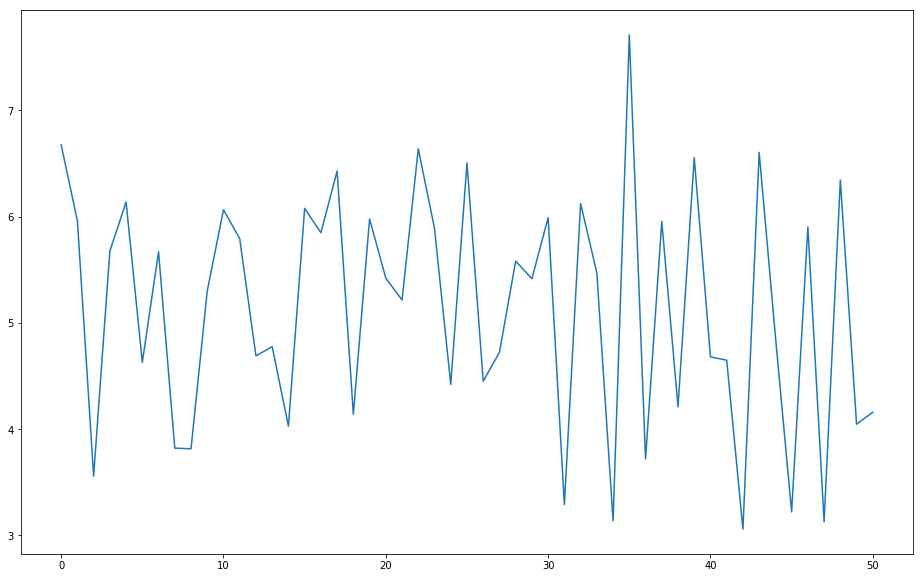

In [174]:
D_prior = normal_coefs[:,0] 
plt.figure(figsize=(16,10))
plt.plot(D_prior)

Теперь посчитаем матрицу ковариаций

In [175]:
Q = np.cov(normal_coefs)

In [176]:
np.shape(Q)

(51, 51)

Экспаншн Кархунена - Луэве по сути есть SVD разложение матрицы ковариаций

In [188]:
F, S, V = np.linalg.svd(Q)

In [189]:
np.shape(F), np.shape(S), np.shape(V)

((51, 51), (51,), (51, 51))

In [190]:
print(S)

[  3.62384216e+00   3.60200088e+00   3.20277019e+00   3.08391397e+00
   2.80654833e+00   2.51985970e+00   2.45209378e+00   2.29358808e+00
   2.17795481e+00   1.96994571e+00   1.78823194e+00   1.75579260e+00
   1.57995634e+00   1.53432199e+00   1.46454090e+00   1.28634015e+00
   1.19639735e+00   1.18005848e+00   1.12431391e+00   9.91413965e-01
   9.40583383e-01   8.76904695e-01   7.88912963e-01   7.25788572e-01
   6.65828504e-01   6.15166618e-01   6.01499485e-01   5.26405170e-01
   5.03853060e-01   4.50530682e-01   4.15391434e-01   3.73019897e-01
   3.21186054e-01   2.83933138e-01   2.32280144e-01   2.19100109e-01
   1.70338767e-01   1.45302714e-01   1.02598656e-01   8.10198259e-02
   6.92032897e-02   5.27581781e-02   4.50663514e-02   3.30677662e-02
   2.61224443e-02   2.37899799e-02   1.14252609e-02   2.86133134e-03
   1.65517474e-03   1.37880549e-15   2.49990426e-16]


In [191]:
b = []
for j in range(len(S)):
    if S[j] < 1:
        b.append(j)
mask = np.ones(len(S), dtype=bool)
mask[b] = False
S_cut = S[mask]
F_cut = F[:,mask]

In [192]:
np.shape(S_cut), np.shape(F_cut)

((19,), (51, 19))

В итоге оставляем 19 максимальных собственных значений из 50

### Реализуем поиск градиента для нового функционала

Новый функционал:
$$
\underset{\xi}{\text min} [S = (D(\xi) - D_{prior}(\xi))^T C_M^{-1} (D(\xi) - D_{prior}(\xi)) + \frac{1}{2} (C(D) - C_{data})(C(D) - C_{data})^T]
$$

Градиент запишется следующим образом:

$$
\frac{dS}{d\xi} = \frac{dS}{dD} \frac{dD}{d\xi}
$$
$$


$$
 =  [\sum_{n=0}^{N-1}  [\frac{\partial L^n}{\partial D} + \lambda^{n+1} \frac{\partial g^n}{\partial D}]  +  [2C_M^{-1} (D - D_{prior}) ]]  [\Phi] [\Sigma]
$$

In [261]:
class KLT_cost_func(With_cost):
    def __init__(self, Nx, Nt, L, T_end, init, left, right, Cdata, Dprior, Cm, mu, F, S):
        self.Nx = Nx
        self.Nt = Nt
        self.L = L
        self.T_end = T_end
        self.init = init
        self.lc = left
        self.rc = right
        self.Cdata = Cdata
        self.Dprior = Dprior
        self.Cm = Cm
        self.mu = mu
        self.F = F
        self.S = S
        
    def Dxi(self, xi):
        mu = np.zeros(len(S)) + self.mu
        
        return self.F @ np.diag(self.S) @ xi + mu 
        
    def KLT_cost(self, xi):
        D = self.Dxi(xi)
        second = self.cost(D)
        first = (D - self.Dprior).T @ self.Cm @ (D - self.Dprior)
        #first = 0
        return first + second

In [262]:
KLT_S = KLT_cost_func(Nx=Nx, Nt=Nt, L = L, T_end = T_end, init = init, left = left, right = right, Cdata = CTR, Dprior= D_prior, Cm = Q, mu = mu, F = F_cut, S = S_cut)

In [263]:
xi1 = np.random.normal(loc=0, scale=1, size=len(S_cut))

In [264]:
new_cost = KLT_S.KLT_cost(xi1)

In [265]:
new_cost

377.60055388075784

In [266]:
D_test = KLT_S.Dxi(xi1)

In [267]:
D_test

array([ 4.14058532,  5.26446086,  3.21484418,  3.85247809,  3.78425323,
        4.68688233,  6.1112595 ,  4.88622494,  4.81161574,  2.87453594,
        6.74741535,  6.38377122,  6.64191039,  5.0293722 ,  6.60364386,
        3.390647  ,  3.14512443,  5.34866164,  6.28444059,  6.74962874,
        3.92190774,  7.42107615,  5.22548338,  4.93558979,  6.15814514,
        4.42392409,  5.22439337,  6.44223407,  6.48710099,  5.57012788,
        4.14968841,  6.15043018,  5.46952356,  5.50651036,  6.33859434,
        5.57644449,  5.17154907,  4.84899746,  5.81834201,  6.83128938,
        4.53689874,  5.45165239,  3.83106296,  4.82361135,  4.68358377,
        6.15947683,  7.84632236,  4.07354134,  6.04820578,  5.16312704,
        5.57694157])

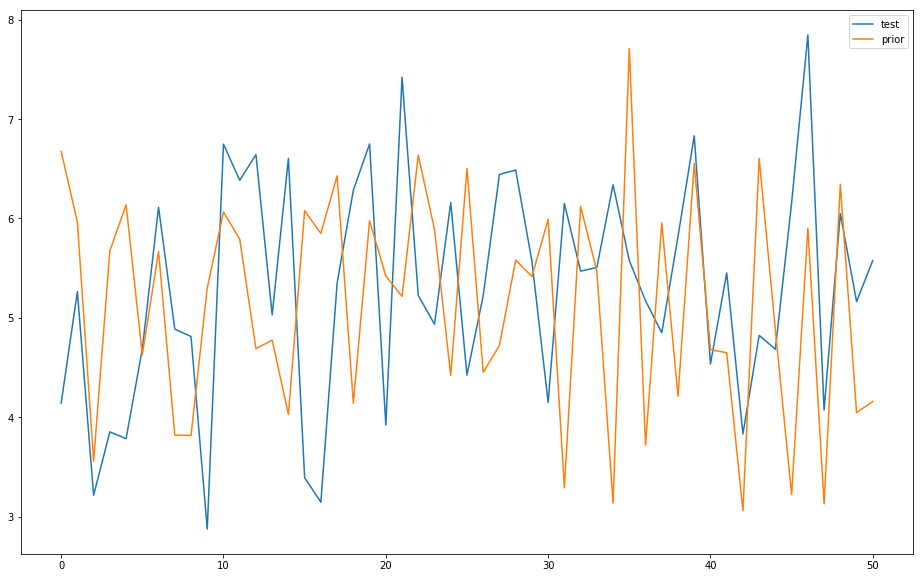

In [268]:
plt.figure(figsize=(16,10))
plt.plot(D_test, label='test')
plt.plot(D_prior, label='prior')
plt.legend(loc='best')

Теперь реализуем поиск градиента для нового функционала

In [269]:
class KLT_gradf(Gradient):
    def __init__(self, Nx, Nt, L, T_end, init, left, right, Cdata, Dprior, Cm, mu, F, S):
        self.Nx = Nx
        self.Nt = Nt
        self.L = L
        self.T_end = T_end
        self.init = init
        self.lc = left
        self.rc = right
        self.Cdata = Cdata
        self.Dprior = Dprior
        self.Cm = Cm
        self.mu = mu
        self.F = F
        self.S = S
        
    def Dxi(self, xi):
        mu = np.zeros(len(S)) + self.mu
        
        return self.F @ np.diag(self.S) @ xi + mu 

    def KLT_grad(self,xi):
        D = self.Dxi(xi)
        first = self.gradf(D)
        second = 2 * self.Cm @ (D - self.Dprior)
        
        third = (first + second) @ self.F @ np.diag(self.S)
        
        
        
        return third / (np.linalg.norm(third)+1e-8)

In [270]:
KLT_gr = KLT_gradf(Nx=Nx, Nt=Nt, L = L, T_end = T_end, init = init, left = left, right = right, Cdata = CTR, Dprior= D_prior, Cm = Q, mu = mu, F = F_cut, S = S_cut)

In [271]:
grad_test = KLT_gr.KLT_grad(xi1)

In [272]:
len(grad_test)

19

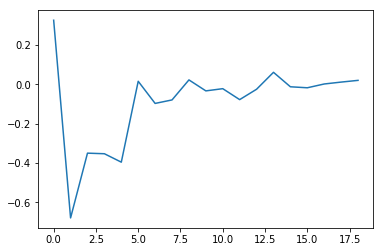

In [273]:
plt.figure()
plt.plot(grad_test)

In [274]:
def GradientDescent(fun, grad, x0,  num_iter, eps, **kwargs):
    x_prev = x0.copy()
    
    iteration = 0

    less = False
    alpha = 1
    x_new = np.zeros(len(x_prev))
    
    sk_prev = - grad(x_prev)
    while True:
        
        if less == True:
            alpha *= 0.5
        
        x_new = x_prev + alpha * sk_prev

        if np.any(x_new <= 0):
            x_new = np.abs(x_new)
        
        gain = (x_new - x_prev) / x_prev
        if gain.T @ gain < eps:
            print(f"gain less that {eps}")
            break

        g_new = grad(x_new)
        g_prev = grad(x_prev)
        f_new = fun(x_new)
        f_prev = fun(x_prev)
        
        pr = (g_new.T @ (g_new - g_prev)) / (g_prev.T @ g_prev)
        #fr = (g_new.T @ g_new) / (gradient.T @ gradient)
        w = np.maximum(0, pr)
        #w = fr    
        
        sk_prev = - g_new + sk_prev * w
        #sk_prev = sk_prev * w
        
        if f_new < f_prev:
            x_prev = x_new
            alpha = 1
            less = False
            
        else:
            less = True
            
            
        print(f"CFV = {f_prev}, less = {less}, alpha = {alpha}, GS = {np.sign(g_prev.T @ g_new)}")
        
        iteration += 1

        if iteration >= num_iter:
            break
        
    res = x_prev
    return res

In [275]:
x0 = xi1 = np.random.normal(loc=0, scale=1, size=len(S_cut))

In [276]:
result = GradientDescent(fun=KLT_S.KLT_cost, grad=KLT_gr.KLT_grad, x0=x0, num_iter=30, eps=1e-8)

CFV = 465.64914428143635, less = False, alpha = 1, GS = 1.0
CFV = 194.6488623381639, less = False, alpha = 1, GS = 1.0
CFV = 174.54911485298942, less = False, alpha = 1, GS = 1.0
CFV = 147.58548557229634, less = False, alpha = 1, GS = 1.0
CFV = 126.96411321261044, less = True, alpha = 1, GS = 1.0
CFV = 126.96411321261044, less = False, alpha = 1, GS = 1.0
CFV = 92.3076593404887, less = True, alpha = 1, GS = 1.0
CFV = 92.3076593404887, less = True, alpha = 0.5, GS = 1.0
CFV = 92.3076593404887, less = True, alpha = 0.25, GS = 1.0
CFV = 92.3076593404887, less = True, alpha = 0.125, GS = 1.0
CFV = 92.3076593404887, less = False, alpha = 1, GS = 1.0
CFV = 89.40549192521206, less = True, alpha = 1, GS = 1.0
CFV = 89.40549192521206, less = True, alpha = 0.5, GS = 1.0
CFV = 89.40549192521206, less = True, alpha = 0.25, GS = 1.0
CFV = 89.40549192521206, less = True, alpha = 0.125, GS = 1.0
CFV = 89.40549192521206, less = True, alpha = 0.0625, GS = 1.0
CFV = 89.40549192521206, less = False, alph

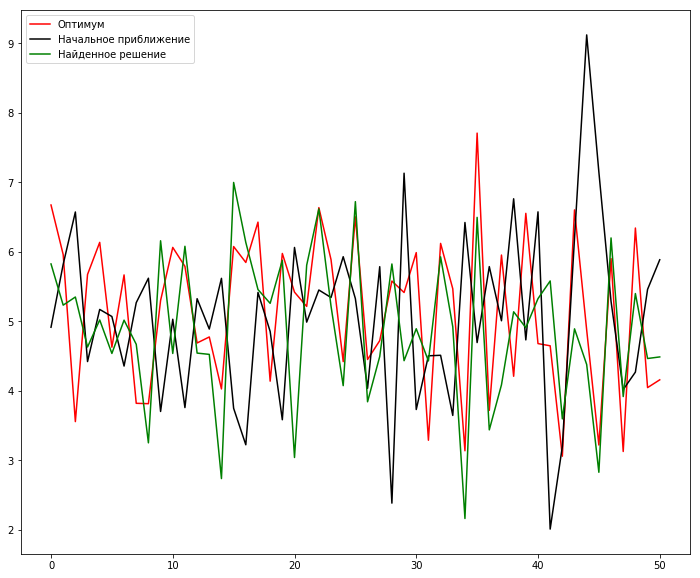

In [278]:
plt.figure(figsize=(12, 10))
plt.plot(D_prior, 'r', label='Оптимум')
plt.plot(KLT_gr.Dxi(x0), 'k', label='Начальное приближение')
plt.plot(KLT_gr.Dxi(result), 'g', label='Найденное решение')
plt.legend(loc='best')
plt.savefig('new_adj.png')